In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

from utils.plotting import RewardHistory
from utils.epsilon import Epsilon
from utils.replay_memory import Transition, ReplayMemory, PrioritisedReplayMemory

import numpy as np
import gym as gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
import time
from IPython import display
import random
import copy
import tensorflow.contrib.eager as tfe
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.WARN)
tf.enable_eager_execution()

%matplotlib inline

/home/william/anaconda3/envs/deeprlbootcamp/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
class LinearModel(tf.keras.Model):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(units=2)

    def call(self, input):
        result = self.dense1(input)
        result = self.dense3(result)
        return result
    
    def loss(self, inputs, actions, targets):
        y = self(inputs)
        
        # y*one_hot
        y = tf.reduce_sum(y * actions, keep_dims=True, reduction_indices=1)
        loss = (y - targets) ** 2 
        return loss
    
    def grad(self, inputs, actions, targets):
        with tfe.GradientTape() as tape:
            l = self.loss(inputs, actions, targets)
            loss_value = tf.reduce_mean(l)
        return tape.gradient(loss_value, self.variables), l
    
    def train(self, optimizer, inputs, actions, targets):
        grads, loss = self.grad(inputs, actions, targets)
        optimizer.apply_gradients(zip(grads, self.variables),
                          global_step=tf.train.get_or_create_global_step())
        return loss


## Tests
model = LinearModel()

model2 = LinearModel()
model2.set_weights(model.get_weights())

# batch = tf.random_uniform([3, 4])
batch = tf.constant([
    [1, 1, 1, 1],
    [-1, -1, -1, -1],
    [1, 1, 1, 1]
], dtype=tf.float32)
print("batch:", batch)

result = model(batch)

print("result:", result)
print("result model2:", model2(batch))

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

# # keep results for plotting
num_epochs = 50

for epoch in range(num_epochs):
    y = tfe.Variable([[5], [10], [5]], dtype="float32")
    a_one_hot = tf.one_hot([1, 0, 1], depth=2, dtype="float32")
    a = tfe.Variable([0, 1, 0], dtype=tf.int32)

#     # Optimize the model
    loss = model.train(optimizer, batch, a_one_hot, y)
#     print("Loss:", loss)
        
print("model 1 after training", model(batch))
print("model 2 stays the same", model2(batch))
model2.set_weights(model.get_weights())
print("model 2 changes after loading weights", model2(batch))


batch: tf.Tensor(
[[ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]], shape=(3, 4), dtype=float32)
result: tf.Tensor(
[[-0.56587434  0.18482837]
 [ 0.01013948 -0.09394669]
 [-0.56587434  0.18482837]], shape=(3, 2), dtype=float32)
result model2: tf.Tensor(
[[-0.21391529  0.10986016]
 [ 0.0911458  -0.49718043]
 [-0.21391529  0.10986016]], shape=(3, 2), dtype=float32)
model 1 after training tf.Tensor(
[[-0.95803815  5.029354  ]
 [10.521026   -0.06633259]
 [-0.95803815  5.029354  ]], shape=(3, 2), dtype=float32)
model 2 stays the same tf.Tensor(
[[-0.21391529  0.10986016]
 [ 0.0911458  -0.49718043]
 [-0.21391529  0.10986016]], shape=(3, 2), dtype=float32)
model 2 changes after loading weights tf.Tensor(
[[-0.95803815  5.029354  ]
 [10.521026   -0.06633259]
 [-0.95803815  5.029354  ]], shape=(3, 2), dtype=float32)


# Ok, now we do DQN with the continuous states received rather than pixels

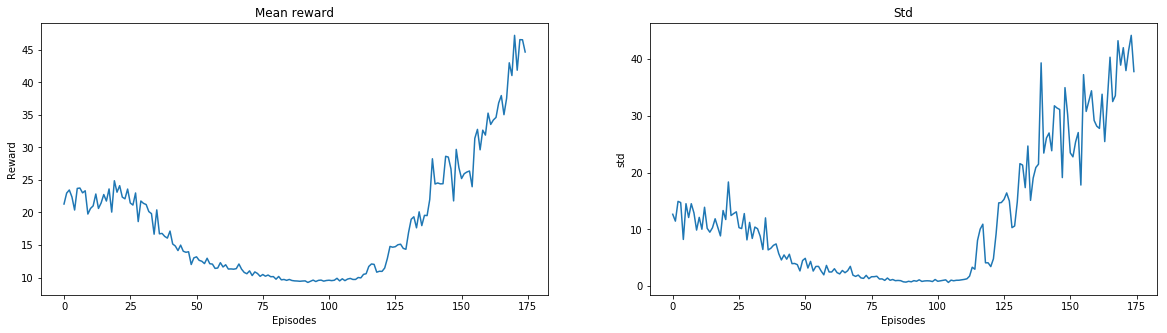

In [13]:
import copy
class DQNLinearLearner(object):
    def __init__(self, env=None, double_Q=False):
        self.env = gym.make("CartPole-v0")
        self.epsilon = Epsilon(start=1.0, end=0.01, update_increment=0.015)
        self.gamma = 0.99
        self.train_q_per_step = 4
        self.train_q_batch_size = 256
        self.steps_before_training = 500
        self.target_q_update_frequency = 100
        
        self.memory = ReplayMemory(capacity=10000)
#         self.memory = PrioritisedReplayMemory(capacity=10000, e=0.1, alpha=0.5)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
        self.Q = LinearModel()
        self.Qt = LinearModel()
        self.Qt.set_weights(self.Q.get_weights())
        
        self.use_double_Q = double_Q

        self.reset()
        self.episode_rewards = []
        self.epsilon_log = []
        self.l_tq_squared_error = deque(maxlen=1000)
        

    def get_action(self, s):
        s = self.state_to_tensor(s)
        actions = self.Q(s).numpy()
        if np.random.rand() > self.epsilon.value():
            action = np.argmax(actions)
        else:
            action = self.env.action_space.sample()
        return action

    def state_to_tensor(self, s):
        x = tf.constant(s, dtype="float32")
        x = tf.expand_dims(x, axis=0)
        return x
    
    def reset(self):
        self.s = self.env.reset()
    
    def train(self, nb_episodes=1, display=None):
        self.epsilon.isTraining = True
        step = 0
        
        for episode in range(nb_episodes):
            self.reset()
            episode_reward = 0
            
            while True:
                action = self.get_action(self.s)
                s_1, r, done, _ = self.env.step(action)
                    
                transition = Transition(self.s, action, s_1, r, done)
                self.memory.push(transition)
                episode_reward += r
                step += 1
                self.s = s_1
                
                if done:
                    break;
                
                if step % self.train_q_per_step == 0 and step > self.steps_before_training:
                    self.train_q()
                    
                if step % self.target_q_update_frequency == 0 and step > self.steps_before_training:
                    self.update_target_q()

            if step > self.steps_before_training:
                self.epsilon.increment() # increment epsilon per episode
            self.episode_rewards.append(episode_reward)
            self.epsilon_log.append(self.epsilon.value())
    
    def train_q(self):
        if self.train_q_batch_size >= len(self.memory):
            return
        
#         transition, indices = self.memory.sample(self.train_q_batch_size)
#         s, a, s_1, r, done = transition
        s, a, s_1, r, done = self.memory.sample(self.train_q_batch_size)
        s = tf.constant(s, dtype=tf.float32)
        a = tf.squeeze(tf.constant(a, dtype=tf.int32))
        a_one_hot = tf.one_hot(tf.squeeze(a), depth=2, dtype=tf.float32)
        s_1 = tf.constant(s_1, dtype=tf.float32)
        r = tf.constant(r, dtype=tf.float32)
        done = tf.constant(1-done, dtype=tf.float32)
        
        
        Qt = self.Qt(s_1)
        if self.use_double_Q:
            best_action = tf.argmax(self.Q(s_1), axis=1)
            best_action = tf.one_hot(best_action, depth=2)
            y = r + done * self.gamma * tf.reduce_sum(Qt*best_action, axis=1, keep_dims=True)
        else:
            y = r + done * self.gamma * tf.reduce_max(Qt, axis=1, keep_dims=True)
    
        loss = self.Q.train(self.optimizer, s, a_one_hot, y)
        
        self.l_tq_squared_error.append(loss.numpy().mean())

    def update_target_q(self):
        self.Qt.set_weights(self.Q.get_weights())
        
    def run(self):
        self.env = gym.make("CartPole-v0")
        self.reset()
        self.epsilon.isTraining = False
        episode_reward = 0
        while True:
            self.env.render()
            action = self.get_action(self.s)
            s_1, r, done, _ = self.env.step(action)
            episode_reward += r
            self.s = s_1

            if done:
                break;
        
        self.env.close()
        print("Total Reward: ", episode_reward)


reward_history = RewardHistory()
for i in range(20):
    learner = DQNLinearLearner(double_Q=False)
    learner.train(175)
    reward_history.append(learner.episode_rewards)

reward_history.plot()

In [ ]:
for i in range(3):
    learner.run()

# Mean reward over 100 training sessions
- Deep Q learning
![mean reward](./images/dqn.png)
- Double Q learning
![mean reward](./images/dqn_double.png)
